In [2]:
from feat import Detector

import os
import cv2

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

## Configuration
The videos will first be converted to separate images.

Afterwards, the images will run through the facial expression detector

In [3]:
image_directory = 'images'
video_directory = 'videos'

# set to True if videos still need to be converted to images
convert_videos = False

# set to True if emotion needs to be extracted from frames
process_frames = False

# set to True if the dataframe with all video ids and emotion counts must be created
create_dataframe = True

## Split video into separate frames
As each video has a frame rate of 30 FPS and we can assume that within one second, 6 frames give enough information on the facial expressions of the person in the frame, one in every 5 frames is extracted to be processed.

In [4]:
# convert video to single images
def write_video_to_frames(path, imdir, videoid):
    
    # load the video
    vidcap = cv2.VideoCapture(path)
    
    # create directory for frames if the directory does not already exist
    try:
        os.mkdir(os.path.join(imdir, videoid))
    except:
        print(f"Directory already exists. Files will be overwritten for {videoid}")
    
    # iterate over frames
    frame_count = 0
    success, image = vidcap.read()
    while success:
        
        # one per 5
        if frame_count % 15 == 0:
            cv2.imwrite(f"{imdir}/{videoid}/frame-{frame_count}.jpg", image)
        
        # read next frame
        success, image = vidcap.read()
        
        # update counter
        frame_count += 1
        
    # log the process
    print(f'Video {videoid} has {frame_count} frames.')

In [5]:
# iterate over videos
if convert_videos:
    # iterate over each video
    for v in os.listdir(video_directory):
        # convert the video into frames
        write_video_to_frames(os.path.join(video_directory, v), image_directory, v.split("_")[0])

## Load the detector
The Py-Feat detector is pre-trained and uses SVM to predict emotions

In [6]:
detector = Detector(emotion_model='svm')

## Process frames to extract emotion
Note that all of the detector outputs are stored in the folder corresponding with the video id.

In [7]:
if process_frames:
    
    # iterate over the images of one video
    for id in os.listdir(f'{image_directory}'):
        
        frame_outputs = []
        max_per_video = 0
        
        # skip the DS_Store file
        if id != '.DS_Store':
            
            # iterate over each image
            for im in os.listdir(f'{image_directory}/{id}'):

                # get the emotions present in the frame
                image_prediction = detector.detect_image(f'{image_directory}/{id}/{im}')
                max_per_video += 1
                
                # stop at 100 frames
                if max_per_video == 100:
                    break
                
                # append emotions to the dataframe
                frame_outputs.append(image_prediction)
                
            # write the outputs to a csv in the same folder as the image
            df_out = pd.concat(frame_outputs)
            df_out.to_csv(f'{image_directory}/{id}/sentiment.csv')

## Add all of the sentiment scores per video in one big dataframe

In [8]:
if create_dataframe:

    # initilialise dataframe including the emotion counts
    sentiment_counts_df = pd.DataFrame(columns=['video_id', 
                                                'ratio', 
                                                'emotion'])

    # iterate over videos
    counter = 0
    for video_id in os.listdir(image_directory):
        
        # skip .DS_Store file
        if video_id == '.DS_Store':
            continue
        
        # load dataframe from the corresponding directory
        sentiment_df = pd.read_csv(f'{image_directory}/{video_id}/sentiment.csv')
        
        # calculate the number of frames in the dataframe
        dfl = len(sentiment_df.index)
        
        # calculate sum of emotions
        anger_count = sentiment_df.anger.sum() / dfl 
        disgust_count = sentiment_df.disgust.sum() / dfl
        fear_count = sentiment_df.fear.sum() / dfl
        happiness_count = sentiment_df.happiness.sum() / dfl
        sadness_count = sentiment_df.sadness.sum() / dfl
        surprise_count = sentiment_df.surprise.sum() / dfl
        neutral_count = sentiment_df.neutral.sum() / dfl
        
        # add anger ratio to dataframe
        sentiment_counts_df.loc[counter, :] = [video_id,
                                            anger_count,
                                            'anger']
        # increase counter
        counter += 1 
        
        # add fear ratio to dataframe
        sentiment_counts_df.loc[counter, :] = [video_id,
                                            fear_count,
                                            'fear']
        # increase counter
        counter += 1 
        
        # add happy ratio to dataframe
        sentiment_counts_df.loc[counter, :] = [video_id,
                                            happiness_count,
                                            'happy']
        # increase counter
        counter += 1 
        
        # add sad ratio to dataframe
        sentiment_counts_df.loc[counter, :] = [video_id,
                                            sadness_count,
                                            'sad']
        # increase counter
        counter += 1 
        
        # add disgust ratio to dataframe
        sentiment_counts_df.loc[counter, :] = [video_id,
                                            disgust_count,
                                            'disgust']
        # increase counter
        counter += 1 
        
        # add surprise ratio to dataframe
        sentiment_counts_df.loc[counter, :] = [video_id,
                                            surprise_count,
                                            'surprise']
        # increase counter
        counter += 1 
        
        # add neutral ratio to dataframe
        sentiment_counts_df.loc[counter, :] = [video_id,
                                            neutral_count,
                                            'neutral']
        # increase counter
        counter += 1    
    
    sentiment_counts_df.to_csv('videos_and_emotions.csv')
   
# otherwise load from file 
else:
    sentiment_counts_df = pd.read_csv('videos_and_emotions.csv')

### Load the sentiment labels corresponding with each video id

In [9]:
label_df = pd.read_csv('labels.csv', delimiter=';')

### Process and merge the emotion count of each video with the labels

In [10]:
# convert data type to float
sentiment_counts_df.ratio = sentiment_counts_df.ratio.apply(lambda l: float(l))

# plot df pivoted on emotion
sent_df = sentiment_counts_df.pivot_table(index='video_id', columns='emotion', values='ratio')

In [11]:
# convert video id to string
sentiment_counts_df.video_id = sentiment_counts_df.video_id.apply(lambda l: str(l))

# convert video id to string
label_df.VideoID = label_df.VideoID.apply(lambda l: str(l))

In [12]:
# merge into one dataframe
merged_df = sent_df.merge(label_df, left_on='video_id', right_on='VideoID')

### Add the total mean and the mean of all negative emotions

In [13]:
# mean of all emotions
sent_df['total_mean'] = sent_df[['anger', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']].mean(axis=1)

# mean of negative emotions only
sent_df['negative_mean'] = sent_df[['anger', 'disgust', 'fear', 'sad']].mean(axis=1)

In [14]:
# store dataframe
sent_df.to_csv("video_features.csv")

### Show overview of the emotion ratios per video

Include annotations in the heatmap to show which video is positive and which video is negative

In [15]:
# create annotations
labels = []

for row in merged_df.Sentiment:
    
    if row == 'Positive':
        labels.append(['+', '+', '+', '+', '+', '+', '+', '+', '+'])
    elif row == 'Postive':
        labels.append(['+', '+', '+', '+', '+', '+', '+', '+', '+'])
    elif row == 'Negative':
        labels.append(['-', '-', '-', '-', '-', '-', '-', '-', '-'])
    else:
        labels.append([' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '])

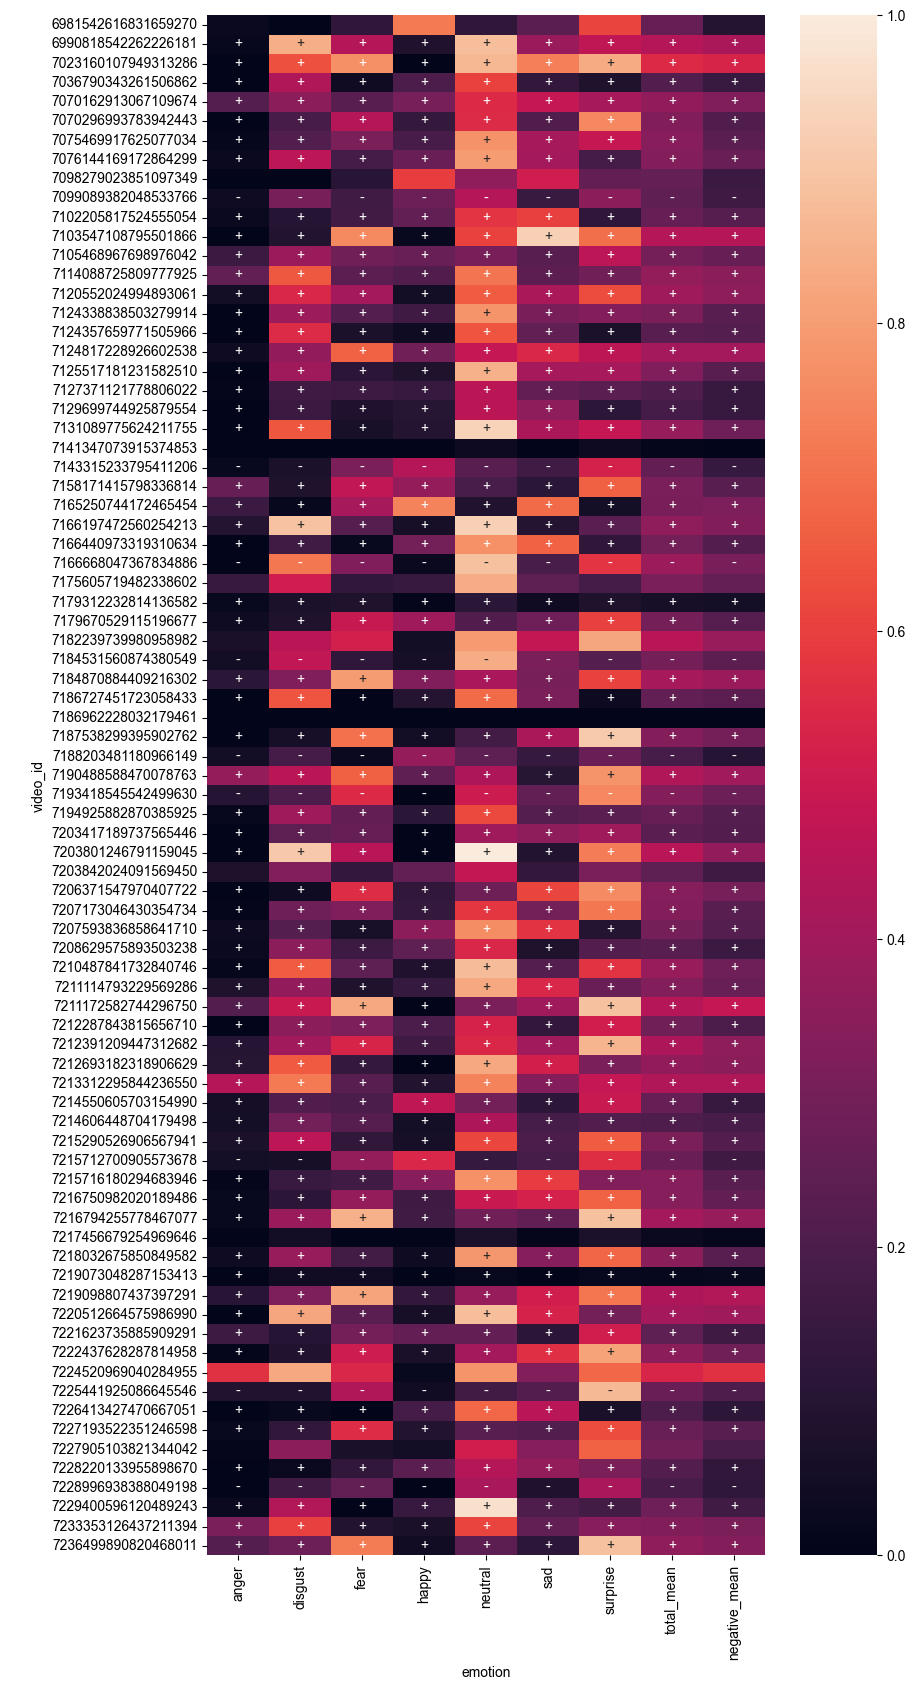

In [16]:
# show heatmap
fig, ax = plt.subplots(figsize=(9,20))
sns.heatmap(sent_df, ax=ax, annot=labels, fmt='s')
sns.set(font_scale=.8)

plt.show()